In [13]:
import numpy as np
from spec_id import Scale_model, Cluster, Cluster_model,Gauss_dist,Divide_cont,Cluster_fit
import matplotlib.pyplot as plt
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [48]:
metal=np.arange(0.002,0.031,0.001)
# age=np.arange(7.0,14.1,.1)
age=np.arange(5.,14.1,.1)
tau=[0]

M,A=np.meshgrid(metal,age)

cluster=[6528,6553,5927,6304,6388,6441]

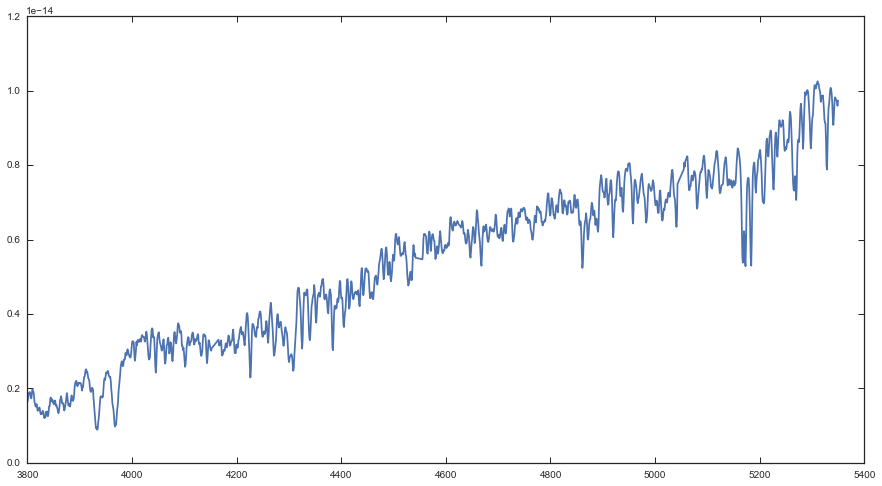

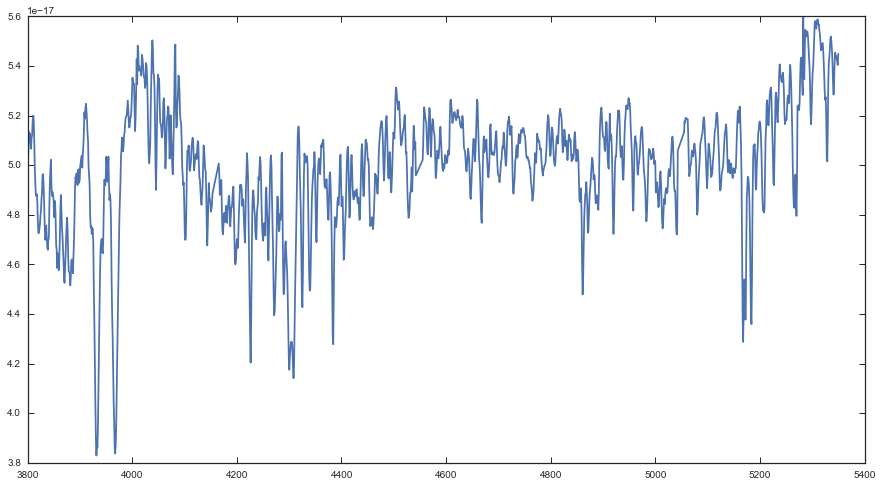

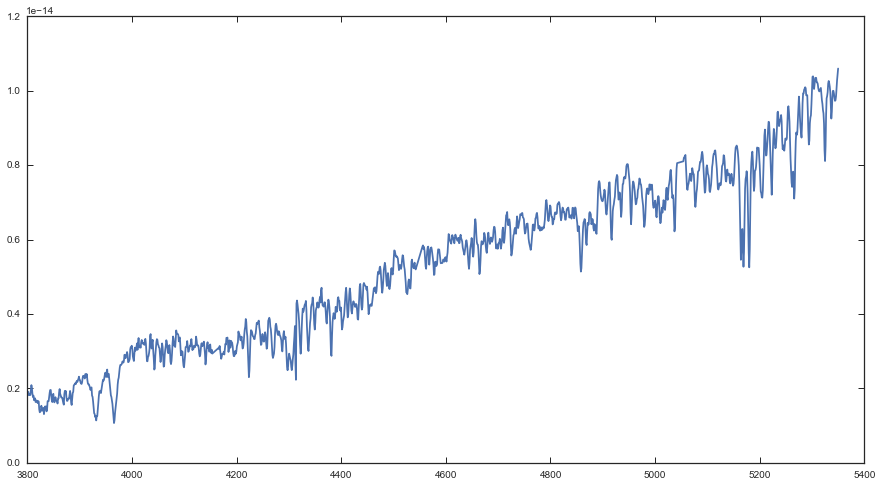

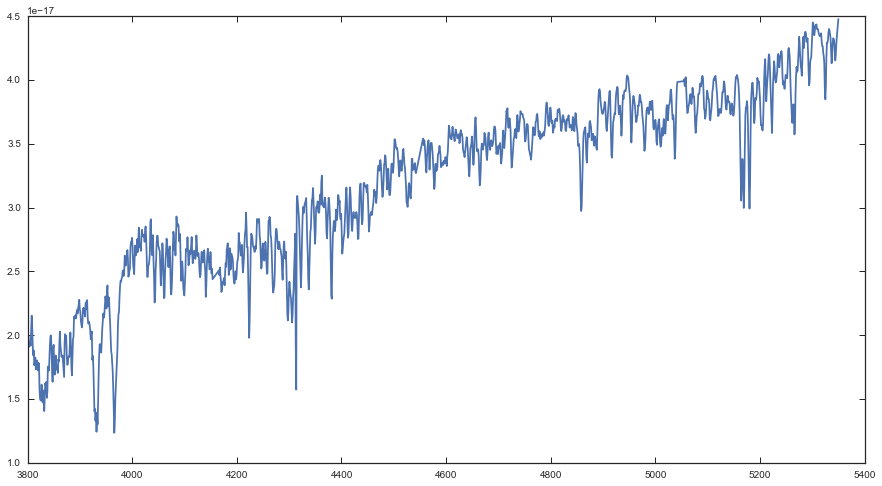

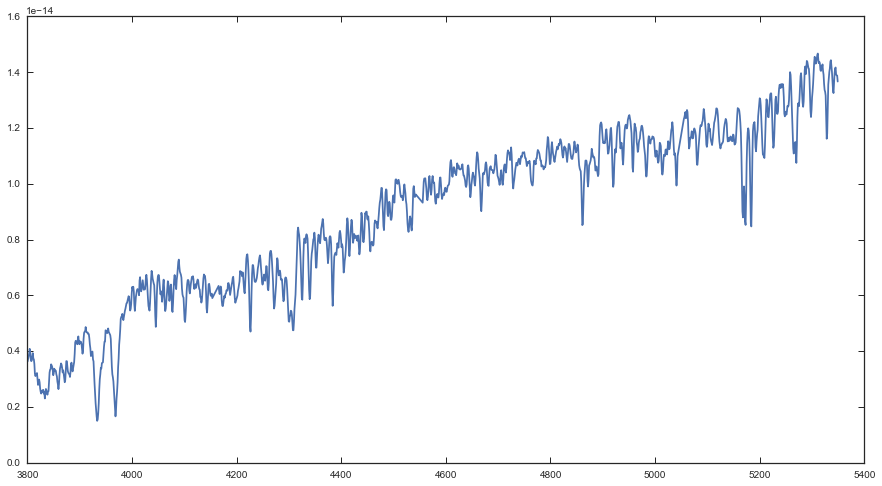

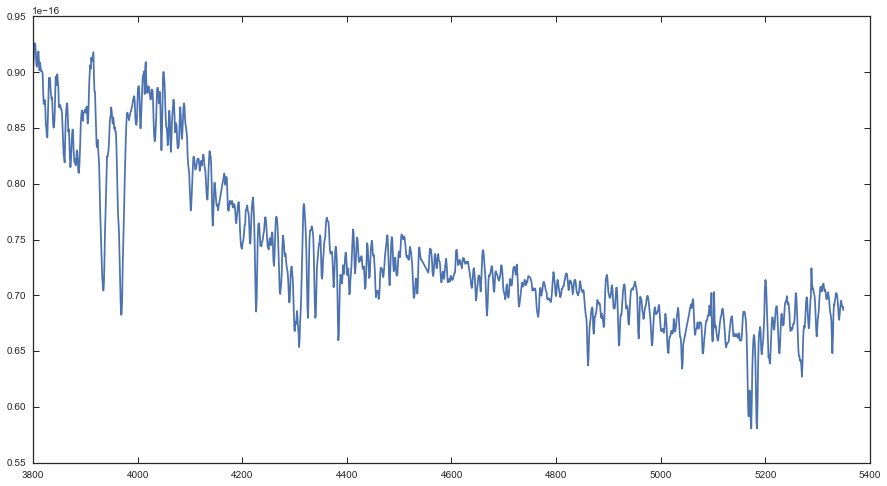

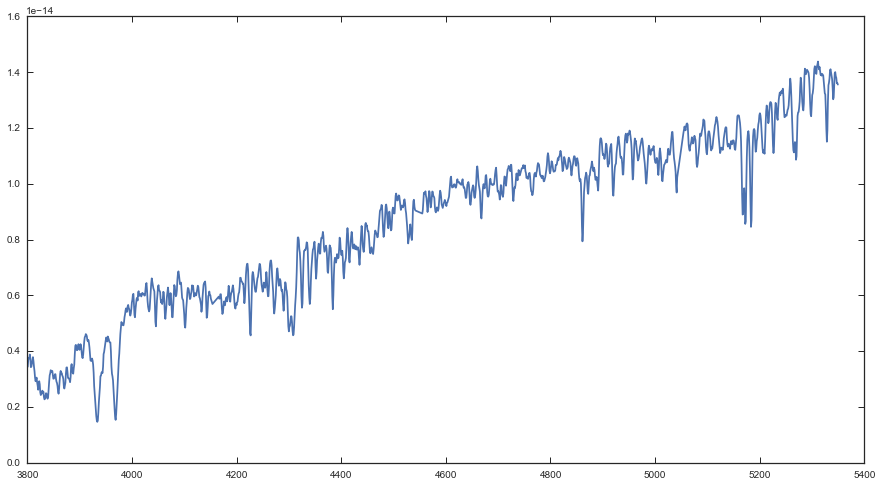

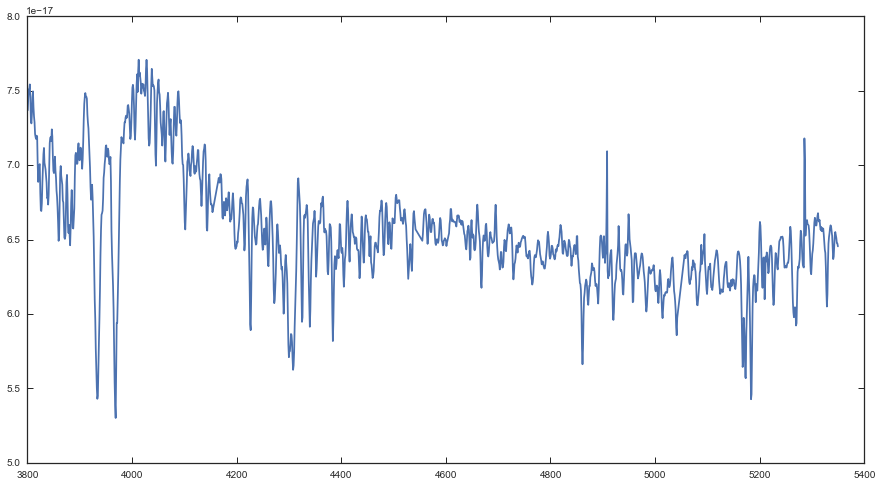

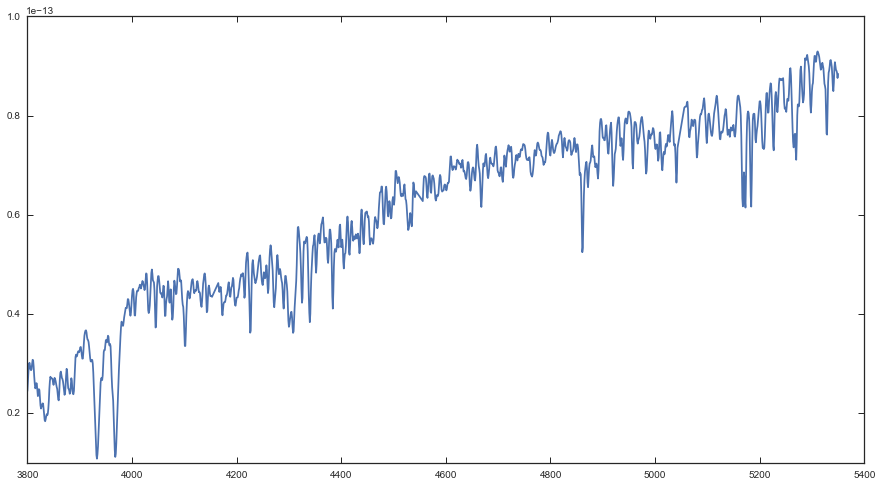

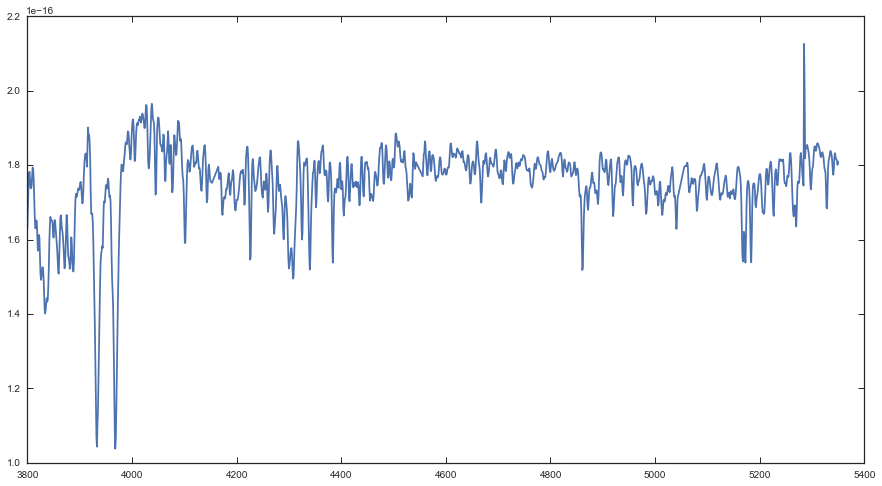

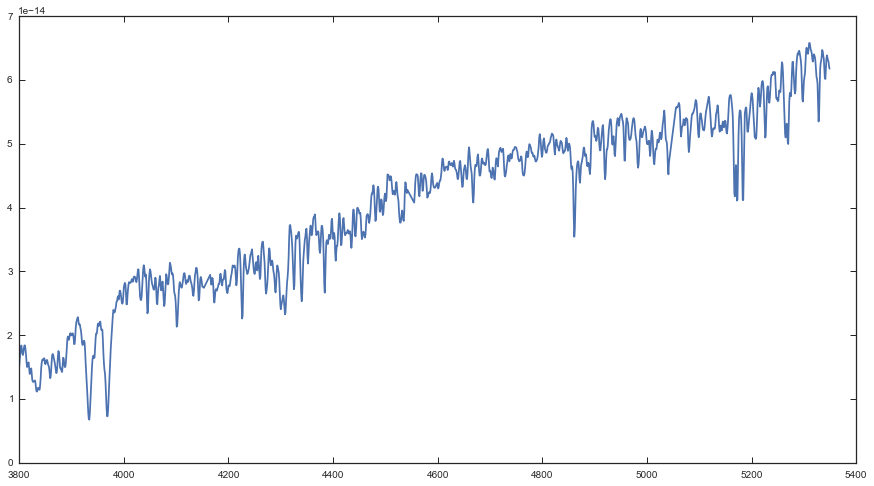

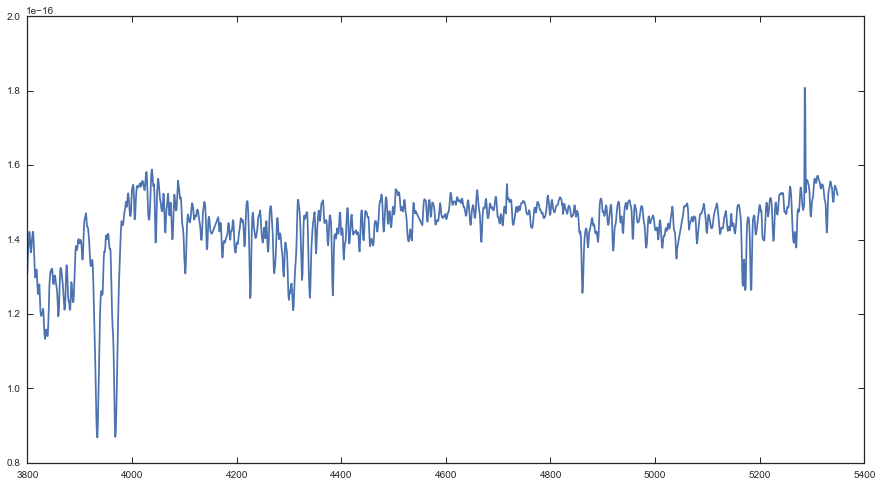

In [3]:
%matplotlib  inline
fp = '../../../cluster_list/'
cluster=[6528,6553,5927,6304,6388,6441]

for i in range(len(cluster)):

    dato= fits.open(fp +'NGC%s_a_1.fits' % cluster[i])
    dat1= fits.open(fp +'NGC%s_a_1.aux.fits' % cluster[i])
        
    start=dat1[0].header['CRVAL1']
    step=dat1[0].header['CDELT1']
    wv=np.arange(start,start+len(dat1[0].data[0])*step,step)
    
    IDc=[U for U in range(len(wv)) if wv[U] < 4154 or 4165 < wv[U] < 4543 or 4555 < wv[U] < 5043 or wv[U] >5054]
    wv=wv[IDc]
    flo=dato[0].data[IDc]
    fl=dat1[0].data[0][IDc]
    sn=dat1[0].data[3][IDc]
    IDX = [U for U in range(len(wv)) if 3800 <= wv[U] <= 5350]
    
    plt.figure(figsize=[15,8])
    plt.plot(wv[IDX],(flo)[IDX])
    plt.show()
    plt.close()
    
    plt.figure(figsize=[15,8])
    plt.plot(wv[IDX],(flo/sn)[IDX])
    plt.show()
    plt.close()


    dat=Table([wv,flo],names=['wv', 'fl'])
    ascii.write(dat,'clusters/ngc%s_spec_fc.dat' % cluster[i])

    dat=Table([wv,flo/sn],names=['wv', 'er'])
    ascii.write(dat,'clusters/ngc%s_err_fc.dat' % cluster[i])

0.324910599727
1.00660369659


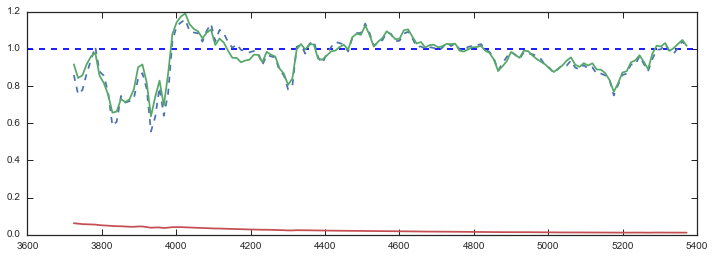

0.75522252717
2.03131783607


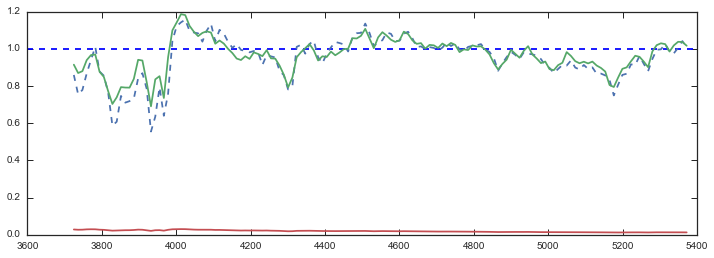

0.484316778678
1.17594586713


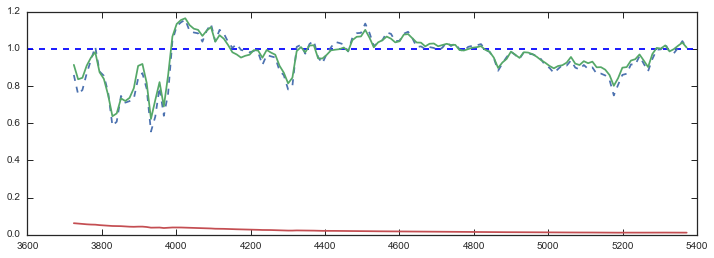

0.590222698691
1.40426072019


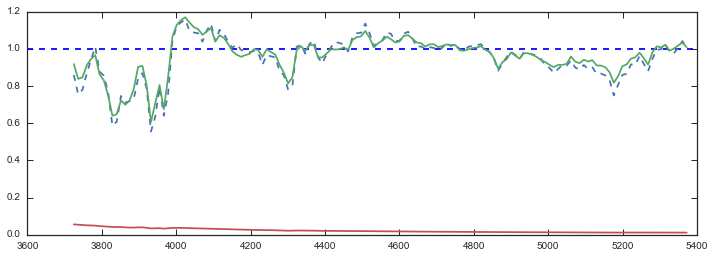

0.776915323291
1.96323670657


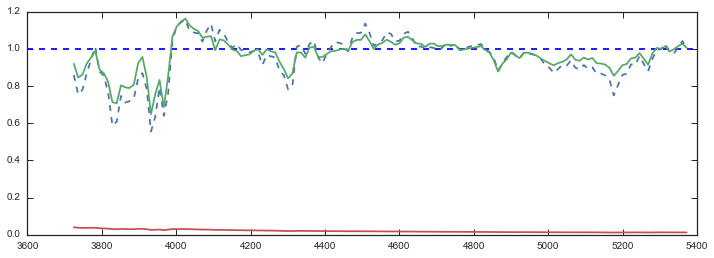

0.660047095589
1.7320553822


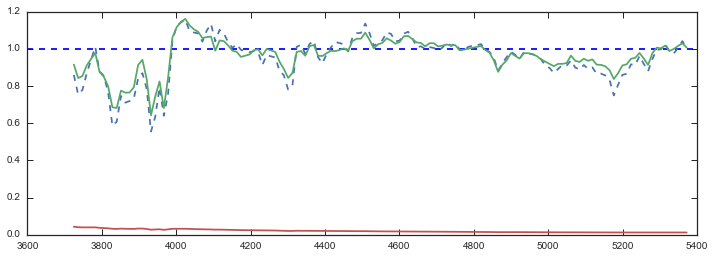

In [9]:
%matplotlib inline
cluster=[6528,6553,5927,6304,6388,6441]

for i in range(len(cluster)):
    wv,fl = np.load('clusters/ngc%s_griz_fc.npy' % cluster[i])
    wv,er = np.load('clusters/ngc%s_err_griz_fc.npy' % cluster[i])
    
    ncwv,ncfl,ncer=Divide_cont(wv,fl,0.016*er,1.1)
    clus_model = Cluster_model(0.015,9.8,wv,fl,er)
    clus_model.Remove_continuum()
    
    imfl = interp1d(clus_model.nc_wv,clus_model.nc_fl)(ncwv)
    
    sres = ((ncfl - imfl)/ncer)
    
    print np.mean(sres)
    print np.std(sres)
    
    np.save('clusters/ngc%s_griz_err_test' % cluster[i],[wv,fl,0.016*er])
    
    plt.figure(figsize=[12,4])
    plt.axhline(1,linestyle='--')
    plt.plot(clus_model.nc_wv,clus_model.nc_fl,'--')
    plt.plot(ncwv,ncfl)
    plt.plot(ncwv,ncer)
    plt.show()
    plt.close()

In [49]:
for i in range(len(cluster)):
    Cluster_fit('clusters/ngc%s_griz_err.npy' % cluster[i],metal,age,'ngc%s_err' % cluster[i])

Done!
Done!


Done!


Done!


Done!


Done!

[[ 6 15]]
Best fit model is 5.6 Gyr and 0.017 Z


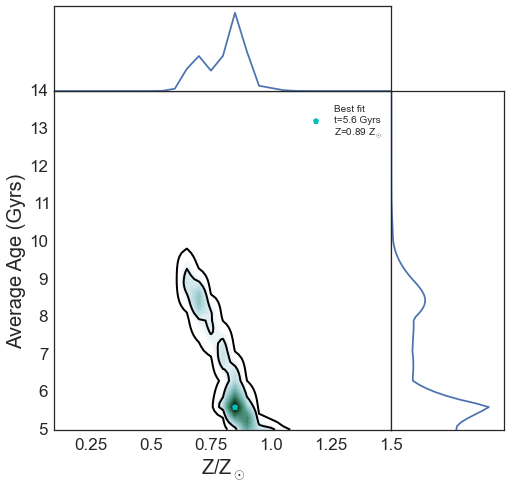

[[1 9]]
Best fit model is 5.1 Gyr and 0.011 Z


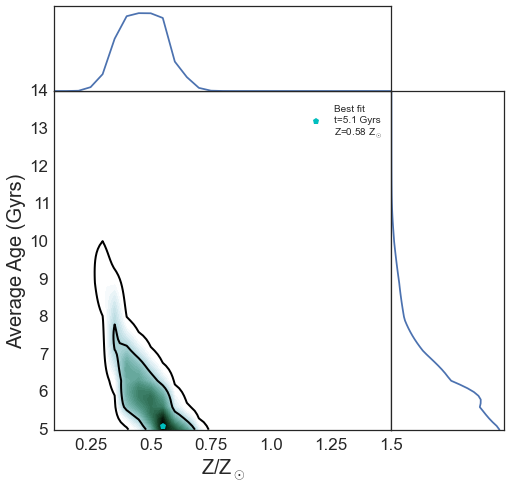

[[30  7]]
Best fit model is 8.0 Gyr and 0.009 Z


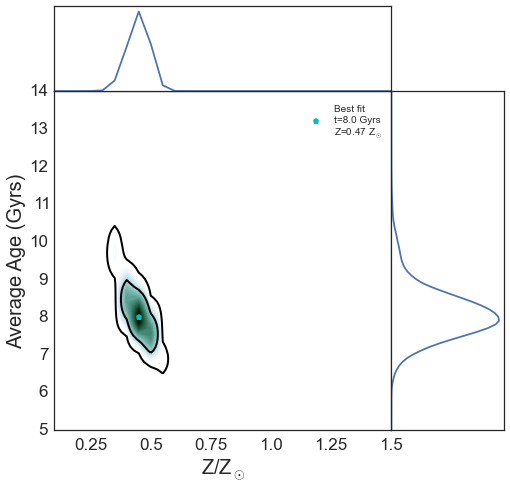

[[20  7]]
Best fit model is 7.0 Gyr and 0.009 Z


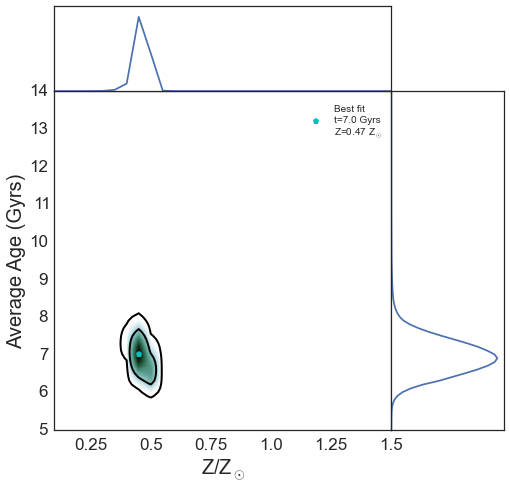

[[2 4]]
Best fit model is 5.2 Gyr and 0.006 Z


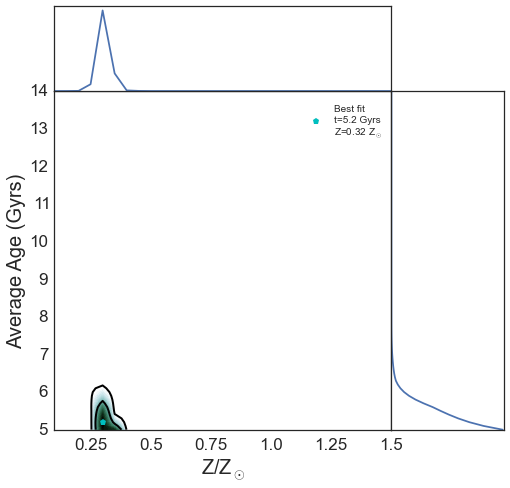

[[0 7]]
Best fit model is 5.0 Gyr and 0.009 Z


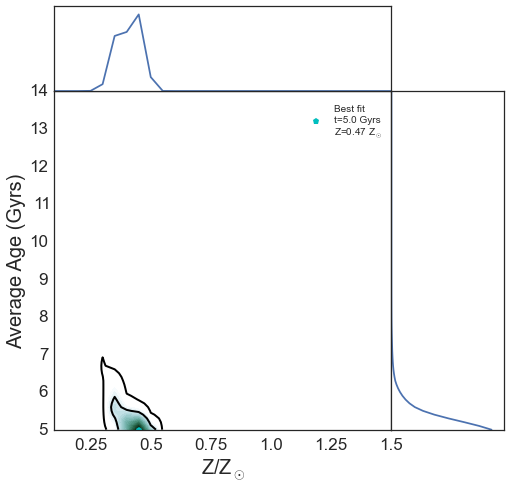

In [50]:
%matplotlib inline

for i in range(len(cluster)):
    ngc=Cluster('clusters/ngc%s_griz_err.npy' % cluster[i])
    ngc.Analyze_fit('chidat/ngc%s_err_chidata.fits' % cluster[i],metal,age)
    ngc.Plot_2D_likelihood()

[[14 12]]
Best fit model is 8.4 Gyr and 0.014 Z


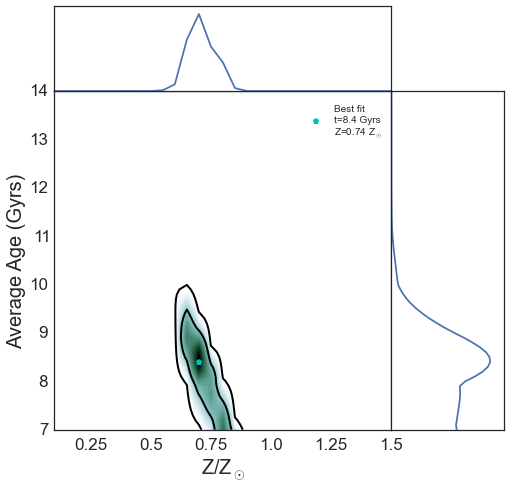

[[0 6]]
Best fit model is 7.0 Gyr and 0.008 Z


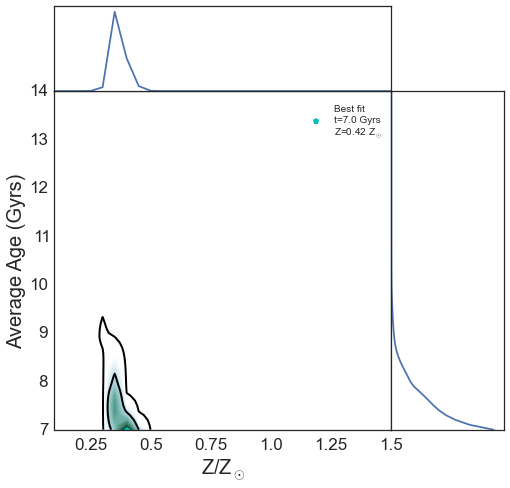

[[10  7]]
Best fit model is 8.0 Gyr and 0.009 Z


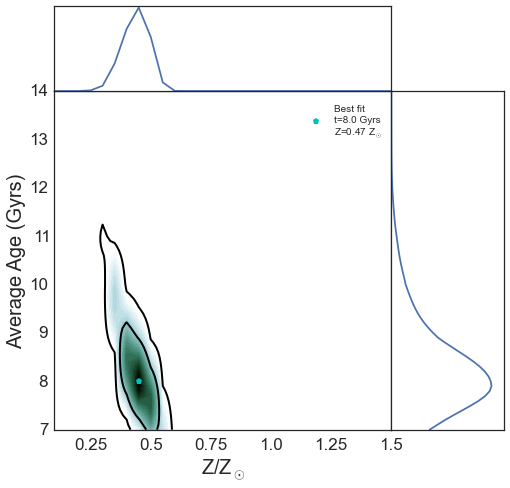

[[0 7]]
Best fit model is 7.0 Gyr and 0.009 Z


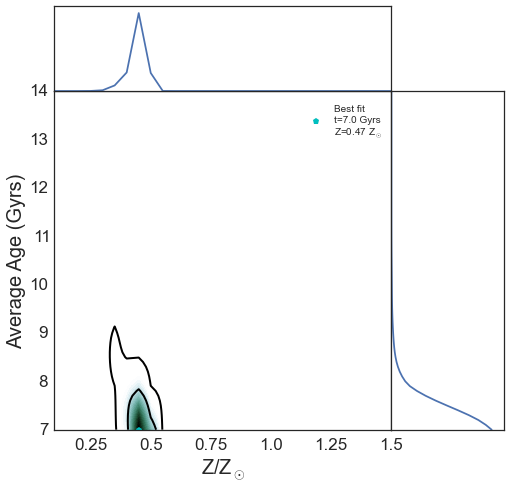

[[0 3]]
Best fit model is 7.0 Gyr and 0.005 Z


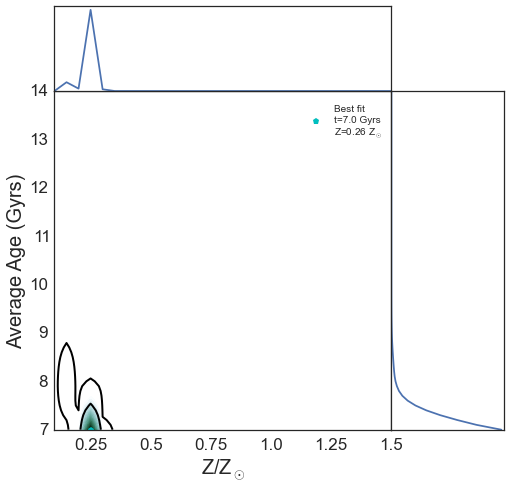

[[0 4]]
Best fit model is 7.0 Gyr and 0.006 Z


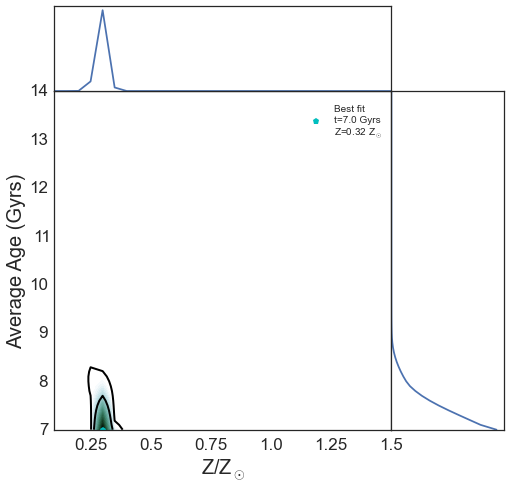

In [18]:
%matplotlib inline

for i in range(len(cluster)):
    ngc=Cluster('clusters/ngc%s_griz_err_test.npy' % cluster[i])
    ngc.Analyze_fit_FC('chidat/ngc%s_err_test_cont_chidata.fits' % cluster[i],'chidat/ngc%s_err_test_feat_chidata.fits' % cluster[i],metal,age)
    ngc.Plot_2D_likelihood()

In [38]:
## if you increase C you lower std(res)

def Minimize_sres(model_wv,model_flux,wv,fl,er):
    C= 0.016
    sres_std = 0
    
    while np.round(sres_std,2) != 1.0:
        ncwv,ncfl,ncer=Divide_cont(wv,fl,C*er,1.1)
        imfl = interp1d(model_wv,model_flux)(ncwv)
        sres = ((ncfl - imfl)/ncer)
        sres_std =  np.std(sres)
        if sres_std > 1.0:
            C += 0.0001
        if sres_std < 1.0:
            C -= 0.0001
                    
    return C 
   
ngc=Cluster('clusters/ngc%s_griz_err_test.npy' % cluster[0])
ngc.Analyze_fit('chidat/ngc%s_err_test_chidata.fits' % cluster[0],metal,age)
ngc.Remove_continuum()
ngc.Best_fit_spec()

wv,fl = np.load('clusters/ngc%s_griz_fc.npy' % cluster[0])
wv,er = np.load('clusters/ngc%s_err_griz_fc.npy' % cluster[0])

clus_model = Cluster_model(ngc.bfmetal,ngc.bfage,wv,fl,er)
clus_model.Remove_continuum()
 
print Minimize_sres(clus_model.nc_wv,clus_model.nc_fl,wv,fl,er)

[[14 12]]
Best fit model is 8.4 Gyr and 0.014 Z
0.0153


[[14 12]]
Best fit model is 8.4 Gyr and 0.014 Z
0.0153


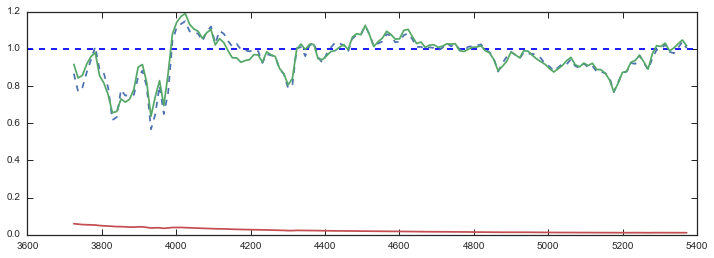

[[0 6]]
Best fit model is 7.0 Gyr and 0.008 Z
0.027

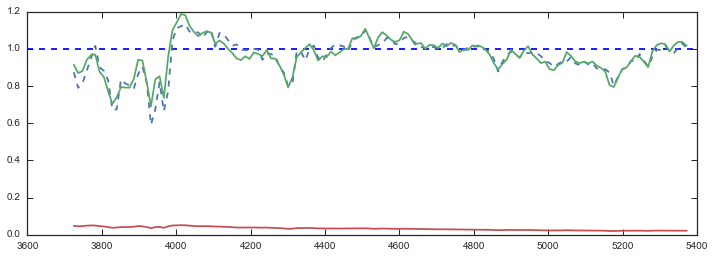

[[10  7]]
Best fit model is 8.0 Gyr and 0.009 Z
0.0122

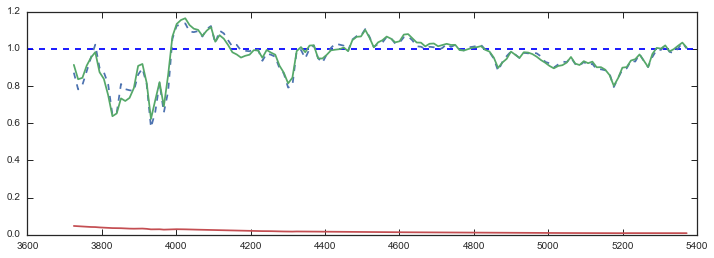

[[0 7]]
Best fit model is 7.0 Gyr and 0.009 Z
0.0143

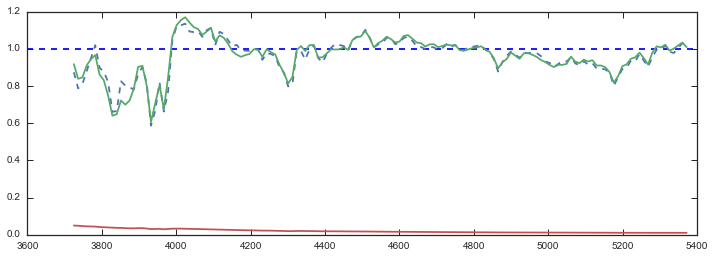

[[0 3]]
Best fit model is 7.0 Gyr and 0.005 Z
0.0145

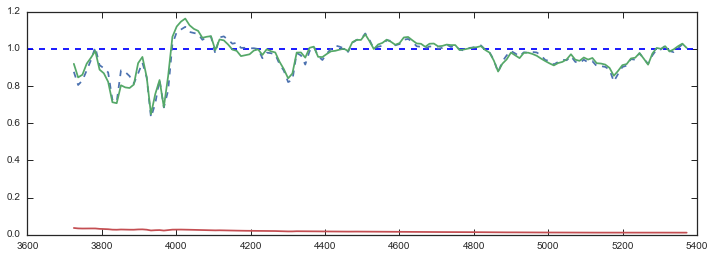

[[0 4]]
Best fit model is 7.0 Gyr and 0.006 Z
0.0149

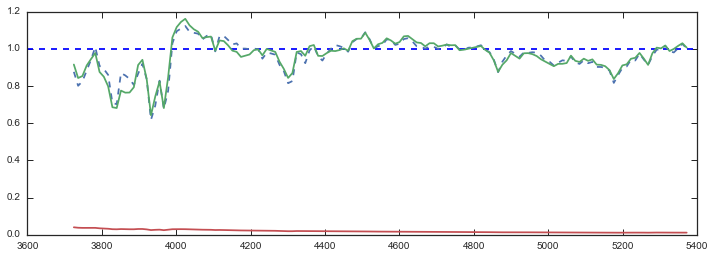

In [39]:
for i in range(len(cluster)):
    ngc=Cluster('clusters/ngc%s_griz_err_test.npy' % cluster[i])
    ngc.Analyze_fit('chidat/ngc%s_err_test_chidata.fits' % cluster[i],metal,age)
    ngc.Remove_continuum()
    ngc.Best_fit_spec()

    wv,fl = np.load('clusters/ngc%s_griz_fc.npy' % cluster[i])
    wv,er = np.load('clusters/ngc%s_err_griz_fc.npy' % cluster[i])
    
    clus_model = Cluster_model(ngc.bfmetal,ngc.bfage,wv,fl,er)
    clus_model.Remove_continuum()

    C0 = Minimize_sres(clus_model.nc_wv,clus_model.nc_fl,wv,fl,er)
    print C0
    ncwv,ncfl,ncer=Divide_cont(wv,fl,C0*er,1.1)
    
    np.save('clusters/ngc%s_griz_err' % cluster[i],[wv,fl,C0*er])
    
    plt.figure(figsize=[12,4])
    plt.axhline(1,linestyle='--')
    plt.plot(clus_model.nc_wv,clus_model.nc_fl,'--')
    plt.plot(ncwv,ncfl)
    plt.plot(ncwv,ncer)
    plt.show()
    plt.close()